In [7]:
import pandas as pd
from sklearn.cluster import Ward
import matplotlib.pyplot as plt
import numpy as np
from pandas import merge
from sklearn.decomposition import PCA
from __future__ import division
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix

Org_Level = 'Org Level 3'

df = pd.read_csv('C:/Users/aclark/Box Sync/Clustering/Department-Clustering\DataFile.csv',
                parse_dates = ['Transaction Date'],
                thousands=',',
                encoding="ISO-8859-1")

supplier_filter = '|'.join(['FISHER SCIENTIFIC',
                            'VWR',
                            'SIGMA ALDRICH',
                            'BIOEXPRESS',
                            'LIFE TECHNOLOGIES CORP',
                            'USA SCIENTIFIC',
                            'DENVILLE',
                            'CLONTECH',
                            'GE HEALTHCARE BIO',
                            'NEW ENGLAND BIO',
                            'SPECTRUM CHEMICAL', 
                            'SPECTRUM LABORATORY',
                            'PROMEGA'
                            ])

df_filtered = df[df['Supplier Normalized Name'].str.contains(supplier_filter) & (df['Spend'] > 0)]

N_Suppliers = df_filtered['Supplier Normalized Name'].nunique()

In [9]:
#Create a set of features for the total spend per supplier per department
Spend_per_Supplier = pd.pivot_table(df_filtered, values='Spend', index=['Campus', Org_Level], 
                                 columns='Supplier Normalized Name', aggfunc=np.sum, fill_value=0)

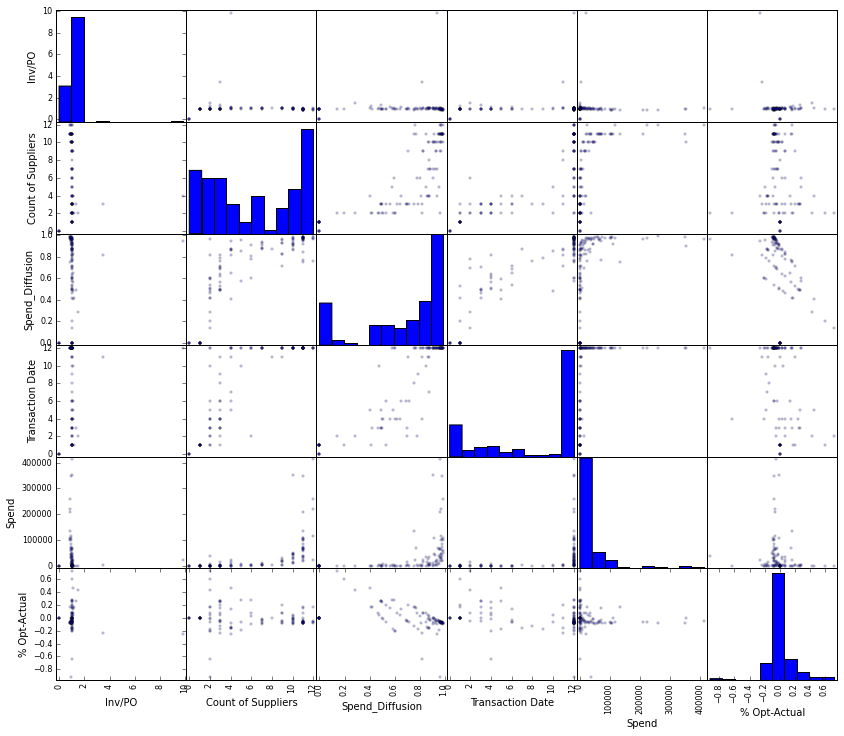

In [24]:
#Create a set of features for the total spend per supplier per department
Spend_per_Supplier = pd.pivot_table(df_filtered, values='Spend', index=['Campus', Org_Level], 
                                 columns='Supplier Normalized Name', aggfunc=np.sum, fill_value=0)

#Create the Invoice Per PO feature
PO_by_Inv = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0)
cutoff = 20
#Replace # of PO = 0 with a .01 so that we can avoid INF errors
PO_by_Inv.replace(0,1,True)
#Divide
PO_by_Inv['Inv/PO'] = (PO_by_Inv['# of Invoices']/PO_by_Inv['# of POs'])
#Take care of inf
PO_by_Inv['Inv/PO'].replace('inf',cutoff,True)
#Drop unnecessary columns
PO_by_Inv = PO_by_Inv.drop(['# of Invoices','# of POs'],1)
#Filter out the outliers and change them to a "cutoff"
PO_by_Inv['Inv/PO'][PO_by_Inv['Inv/PO'] > cutoff] = cutoff


#Create the supplier count feature
Count_Supplier= DataFrame(pd.pivot_table(df_filtered, index=['Campus',Org_Level],values='Supplier Normalized Name',aggfunc=lambda x: len(x.unique())))
Count_Supplier = Count_Supplier.rename(columns={'Supplier Normalized Name':'Count of Suppliers'})

#Create the Spend Diffusion Metric
Max_Supplier_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Supplier Normalized Name'], 
                                          values=['Spend'], aggfunc=np.max, fill_value=0).reset_index().groupby(['Campus',Org_Level]).max().drop(['Supplier Normalized Name'],1)
Total_Dept_Spend = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend'], aggfunc=np.sum, fill_value=0)
Spend_Diffusion = 1-(Max_Supplier_Spend/Total_Dept_Spend)
Spend_Diffusion = Spend_Diffusion.rename(columns={'Spend':'Spend_Diffusion'})
Log_Spend_Diffusion = pd.DataFrame(np.log(Spend_Diffusion))

#Create Spend Frequency and Average Monthly Spend/PO/Invoice Features
Dept_Summary = pd.pivot_table(df_filtered, index=['Campus',Org_Level], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
#pivot out by campus, department, and date then find the summary stats of the time based dimensions
#Create a frame that is grouped by month and sum of all values
dept_time = pd.pivot_table(df_filtered, index=['Campus',Org_Level,'Transaction Date' ], values=['Spend','# of POs', '# of Invoices'], aggfunc=np.sum, fill_value=0).reset_index()
dept_time = dept_time.groupby(['Campus',Org_Level,dept_time['Transaction Date'].map(lambda x: (x.month,x.year))]).sum().reset_index()
avg_monthly = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).mean()['Spend'])
Count_Months = pd.DataFrame(dept_time.groupby(['Campus',Org_Level]).count()['Transaction Date'])

#Merge all the features into the Department_Analysis Frame (Un-comment to run these)
Department_Analysis = pd.merge(Spend_per_Supplier,PO_by_Inv,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Count_Supplier,left_index=True, right_index=True,how='left')
Department_Analysis = pd.merge(Department_Analysis,Spend_Diffusion,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,Count_Months,left_index=True, right_index=True,how='left').fillna(0)
Department_Analysis = pd.merge(Department_Analysis,avg_monthly,left_index=True, right_index=True,how='left').fillna(0)

#For some reason 1/Department_Analysis['Count of Suppliers'] didn't work so I created column of all 1
Department_Analysis['one']=1
Department_Analysis['Optimal Diffusion']= Department_Analysis['one']-(Department_Analysis['one']/Department_Analysis['Count of Suppliers'])
Department_Analysis['% Opt-Actual']=(Department_Analysis['Optimal Diffusion']-Department_Analysis['Spend_Diffusion'])/Department_Analysis['Optimal Diffusion']
Department_Analysis['% Opt-Actual']=Department_Analysis['% Opt-Actual'].fillna(0)
Department_Analysis[Department_Analysis['Spend_Diffusion']== -np.inf] = 0
Department_Analysis[Department_Analysis['% Opt-Actual']== -np.inf] = 0

del Department_Analysis['one']
del Department_Analysis['Optimal Diffusion']

#Calculate the number of non-Supplier Spend dimensions
NonSupplier_Features = len(Department_Analysis.columns) - N_Suppliers

#Create a scatterplot matrix to analyze the features
scatter_matrix(Department_Analysis.ix[:,-NonSupplier_Features:], alpha=0.2, figsize=(14, 12))


#This is a standardization of each columnwise data element by subtracting the column mean and dividing by the column standard deviation.
for col in Department_Analysis.columns:
    Department_Analysis[col + '_stdard'] = (Department_Analysis[col] - Department_Analysis[col].mean()) / Department_Analysis[col].std()

In [19]:
for i in Department_Analysis.columns:print(i)

BIOEXPRESS LLC
CLONTECH LABS INC
DENVILLE SCIENTIFIC
LIFE TECHNOLOGIES CORP
NEW ENGLAND BIOLABS
PROMEGA BIOSCIENCE INC
SIGMA ALDRICH INC
SPECTRUM CHEMICALS & LABORATORY PRODUCTS
STANLEY STOCKROOM VWR
THERMO FISHER SCIENTIFIC INC
USA SCIENTIFIC INC
VWR INTERNATIONAL INC
Inv/PO
Count of Suppliers
Spend_Diffusion
Transaction Date
Spend
% Opt-Actual


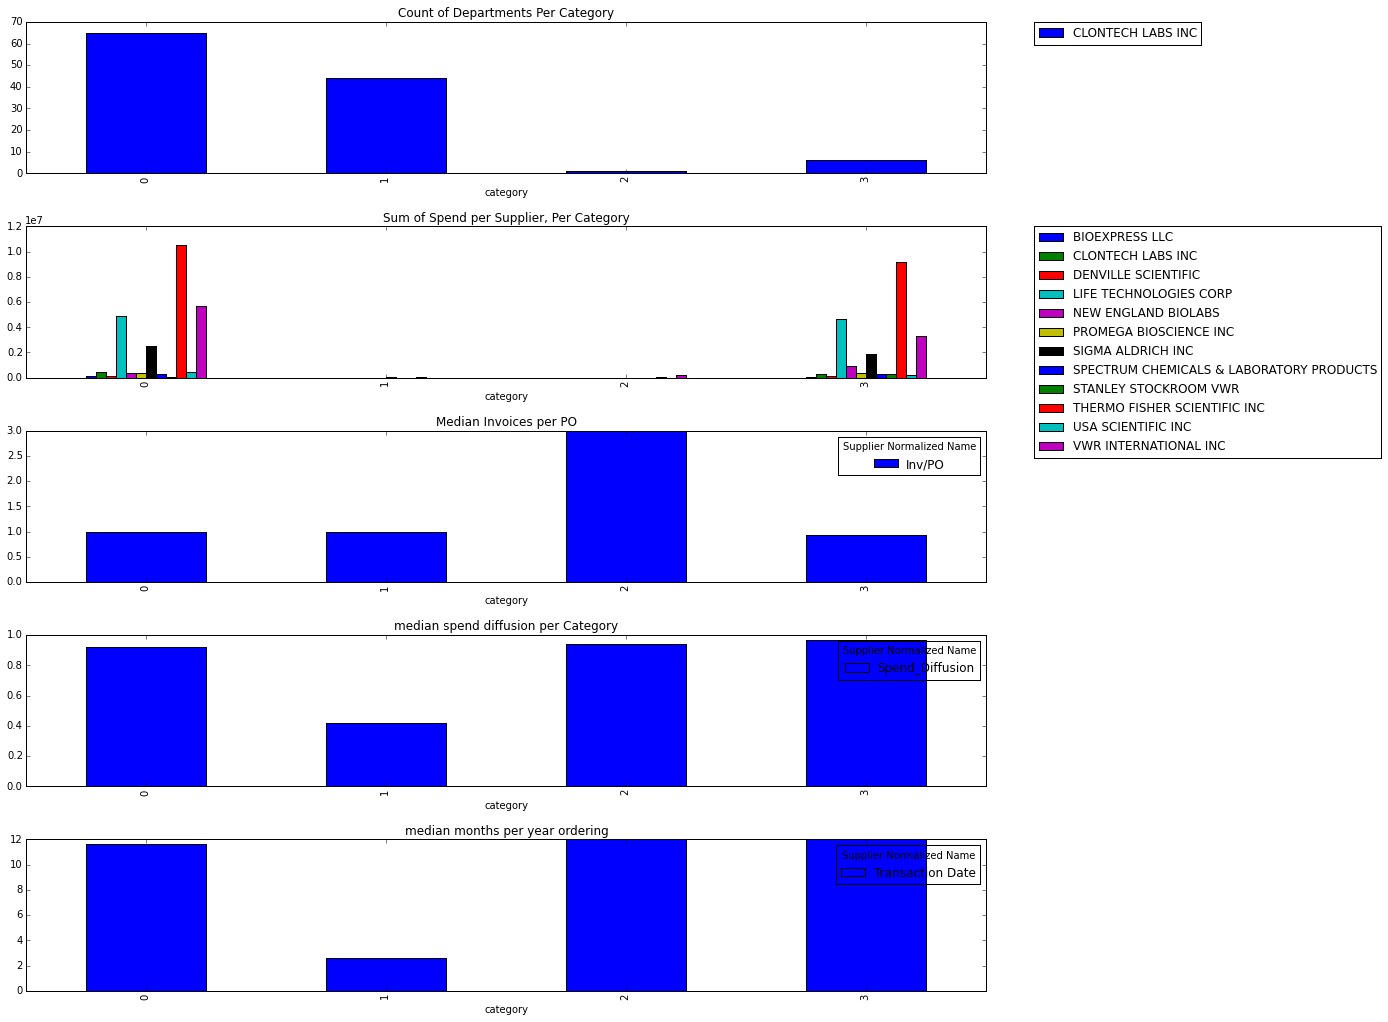

In [34]:
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)

#Run the heirarchical clustering
agglomerativeClustering = AgglomerativeClustering(n_clusters=4)
Department_Analysis['category'] = agglomerativeClustering.fit_predict(Department_Analysis.ix[:,-NonSupplier_Features:])

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None).legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

In [16]:
Department_Analysis[Department_Analysis['category']==1]

Supplier Normalized Name               BIOEXPRESS LLC  CLONTECH LABS INC  \
Campus Org Level 3                                                         
UCB    College of Engineering                    0.00             641.70   
       College of Natural Resources           6171.71           18751.03   
       School of Public Health                   0.00            3531.41   
UCSF   D_Cell and Tissue Biology               149.44            2985.09   
       F_FIN Supply Chain Management             0.00               0.00   
       M_Anatomy                                 0.00           16835.33   
       M_Anesthesia                              0.00            5343.64   
       M_Biochemistry and Biophysics          3781.80           34232.61   
       M_Bioengineering                      10936.86            1173.20   
       M_CMP (Cellular Molecular Pha)         9824.85           26754.02   
       M_Cardiovascular Research Inst         1066.27           22050.16   
       M_Dermatology                          3631.48            4232.17   
       M_Diabetes Center                      7875.37           52195.49   
       M_Epidemiology & Biostatistics            0.00            1534.87   
       M_HDF Comprehensive Cancer Ctr         4488.11            4037.19   
       M_IND (Neurodegenerative Dis)          9051.19            4592.68   
       M_Laboratory Medicine                    40.96           55473.96   
       M_Microbiology and Immunology            65.25           29420.52   
       M_Neurological Surgery                18357.87           14936.00   
       M_Neurology                             720.32           14453.37   
       M_ObGyn, Reproductive Sciences          382.32            1419.43   
       M_Orthopaedic Surgery                     0.00             516.88   
       M_PEDIATRICS                              0.00            6496.39   
       M_Pathology                             601.80            4916.00   
       M_Psychiatry                            366.23           12810.02   
       M_Radiology                               0.00               0.00   
       M_Regeneration Medicine                   0.00           45533.20   
       M_Urology                               715.37            5571.86   
       P_Bioengineering                       7746.92           15622.45   
       P_Pharmaceutical Chemistry             5392.48           12870.36   

Supplier Normalized Name               DENVILLE SCIENTIFIC  \
Campus Org Level 3                                           
UCB    College of Engineering                       199.10   
       College of Natural Resources               26226.23   
       School of Public Health                     6457.71   
UCSF   D_Cell and Tissue Biology                   2522.04   
       F_FIN Supply Chain Management                  0.00   
       M_Anatomy                                   5930.77   
       M_Anesthesia                                 732.26   
       M_Biochemistry and Biophysics               6491.05   
       M_Bioengineering                               0.00   
       M_CMP (Cellular Molecular Pha)              4490.54   
       M_Cardiovascular Research Inst              3502.35   
       M_Dermatology                                  0.00   
       M_Diabetes Center                           1775.09   
       M_Epidemiology & Biostatistics               531.80   
       M_HDF Comprehensive Cancer Ctr              2740.89   
       M_IND (Neurodegenerative Dis)               1477.10   
       M_Laboratory Medicine                       1561.42   
       M_Microbiology and Immunology              28564.14   
       M_Neurological Surgery                      1766.74   
       M_Neurology                                 5014.35   
       M_ObGyn, Reproductive Sciences              1542.57   
       M_Orthopaedic Surgery                        360.19   
       M_PEDIATRICS                                 767.46   
       M_Patholog

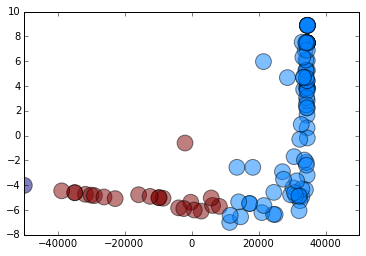

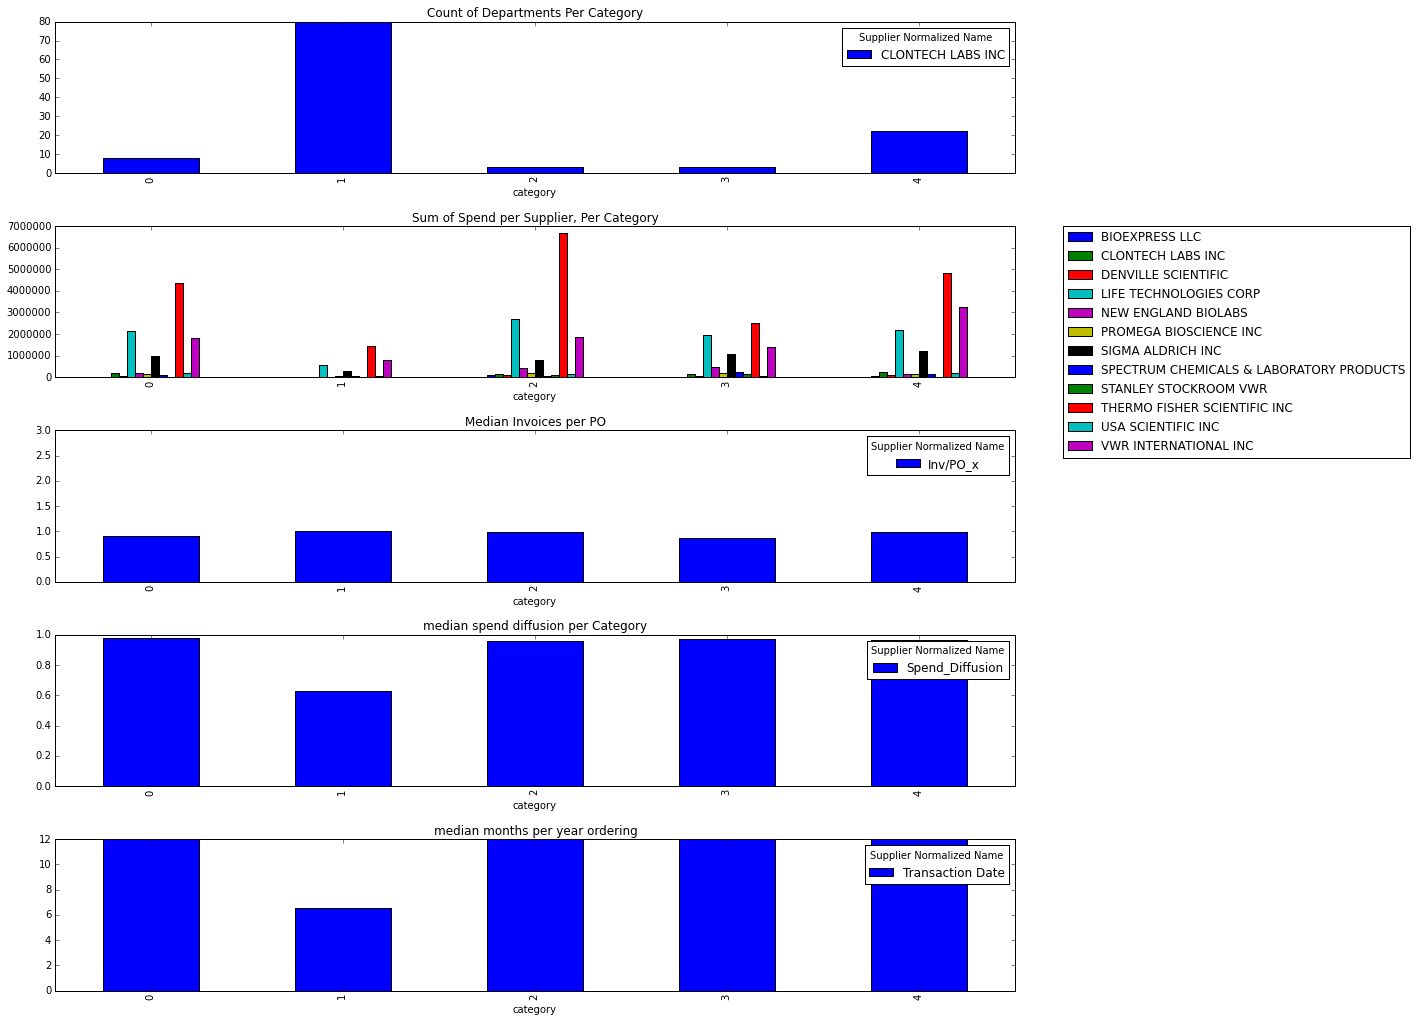

In [5]:
from sklearn.cluster import KMeans
%matplotlib inline

#Drop the category column if it exists
for col in Department_Analysis.columns:
    if col is 'category':
        Department_Analysis = Department_Analysis.drop(col,1)
        
        
#Use PCA to reduce dimensionality to 2 to check the variance explained and inspect the clusters
pca = PCA(n_components=3).fit_transform(Department_Analysis.ix[:,-NonSupplier_Features:])
pcaT = PCA(n_components=3).fit(Department_Analysis.ix[:,-NonSupplier_Features:])


#Run KMeans clustering
kmeans = KMeans(n_clusters=5)
Department_Analysis['category'] = kmeans.fit_predict(Department_Analysis.ix[:,-NonSupplier_Features:])

#Run PCA and chart the two leading Components to see what the clusters look like in 2D space
sc = plt.scatter(pca[:,0],pca[:,1], s=250, c=Department_Analysis.category, alpha=0.5, edgecolors='black')
plt.xlim(-50000,50000)
plt.legend()
plt.show()

#Group the data by supplier and plot it to see the spend per supplier/per cluster.
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(14, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=.35)
ax1 = Department_Analysis.groupby('category').count()[[1]].plot(kind='bar',ax=axes[0], title='Count of Departments Per Category', label=None)
ax2 = Department_Analysis.groupby('category').sum()[[x for x in Department_Analysis.columns[0:N_Suppliers]]].plot(kind='bar',ax=axes[1], title='Sum of Spend per Supplier, Per Category').legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax3 = Department_Analysis.groupby('category').median()[['Inv/PO_x']].plot(kind='bar',ax=axes[2], title='Median Invoices per PO')
ax3.set_ylim(0,3)
ax4 = Department_Analysis.groupby('category').median()[['Spend_Diffusion']].plot(kind='bar',ax=axes[3], title='median spend diffusion per Category')
ax4.set_ylim(0,1)
ax5 = Department_Analysis.groupby('category').mean()[['Transaction Date']].plot(kind='bar',ax=axes[4], title='median months per year ordering')

,Campus,UNSPSC Level 1,UNSPSC Level 2,Tier 2 - UC Procurement Scope,Tier 3 - UC Category Group,Spend,Supplier Normalized Name,Org Level 3,Org Level 4,Org Level 5,Transaction Date,# Suppliers,# of Lines,# of POs,# of Invoices,Discount Amount
0,NaN,NaN,NaN,NaN,NaN,"1,637,736,897.57",NaN,NaN,NaN,NaN,NaN,NaN,"2,079,732",NaN,NaN,NaN
1,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"7,607,608.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/1/2014,1,11,11,11,0
2,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"36,461.85",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/10/2014,1,1,1,1,0
3,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"692,785.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/11/2014,1,1,1,1,0
4,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"57,564.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/15/2014,1,1,1,1,0
5,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"1,093,716.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/16/2014,1,1,1,1,0
6,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"404,601.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/18/2014,1,8,7,8,0
7,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"6,761,312.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,12/19/2014,1,6,6,6,0
8,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"24,193.55",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,1/26/2015,1,1,1,1,0
9,UCB,72 - Building and Facility Construction and Ma...,12 - Nonresidential building construction serv...,Non-Traditional,Building Construction,"1,047,252.00",MCCARTHY BUILDING COMPANIES INC,Real Estate,Construction and Design,C and D - Non-Ops Projects,1/27/2015,1,13,11,13,0
